# Kubeflow Stats

* Notebook containing some plots of Kubeflow usage based on spartakus metrics

In [19]:
import datetime
import numpy as np

In [2]:
# Install and pin to versions that seem to work together
!pip3 install pandas-gbq==0.10.0  google-cloud-bigquery==1.11.2 google-api-core==1.8.2
!pip3 install matplotlib

  Using cached https://files.pythonhosted.org/packages/6a/65/bc46678a5550c0cef1700d7292319deae716751af3f6158250d6a3a454ed/pandas_gbq-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b3/33/236bdc6f5204bed8f69aecbabbe1a9b3a5be51f959fb51eba0545181ffa0/google_cloud_bigquery-1.11.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7d/73/e4877e921fe59307ec6b1b0b0c2ad9fde2d1c6bab8dd06ec913891a20dc6/google_api_core-1.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/89/c5/03b68c114bc2c2bcaa2e40fdf269a14361fa75b70a09415e8bad65413b75/pydata_google_auth-0.1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/74/a2/1323b1bce9935ac948cd4863509de16cf852cd80b12dd29e648c65fea93d/google_auth_oauthlib-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/9a/7eb9952f4b4d73fbd75ad1d5d6112f407e695957444cb695cbb3cdab918a/pandas-0.25.0-cp36-cp36m-manylinux1_x86_64

  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/51/f45cea425fd5cb0b0380f5b0f048ebc1da5b417e48d304838c02d6288a1e/setuptools-41.0.1-py2.py3-none-any.whl


In [3]:
# Inline all matplotlib plots
%matplotlib inline

In [4]:
from google.cloud import bigquery

In [5]:
# NOTE: The RuntimeWarnings (if any) are harmless. See ContinuumIO/anaconda-issues#6678.
import pandas as pd
from pandas.io import gbq


In [6]:
# Note: access to this project is restricted
PROJECT="kubeflow-usage"

In [7]:
# We need to filter out empty timestamps because they can't be converted to dates
# Why would pings be missing a timestamp

# Get data for last year
max_age_hours = 24 * 365
query = """
    select TIMESTAMP_SECONDS(cast(timestamp as int64)) as timestamp, clusteriD FROM usage.collector 
    where timestamp is not null and length(timestamp) > 0 and
    timestamp_diff(CURRENT_TIMESTAMP(), TIMESTAMP_SECONDS(cast(timestamp as int64)), HOUR) < {max_age_hours}
""".format(max_age_hours=max_age_hours)

data=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)


/home/jlewi/.local/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Compute cluster stats


In [8]:
# Good reference for working with aggregations
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
aggregations = {
    "timestamp": {
        "min_timestamp": "min",
        "max_timestamp": "max",
        "count": "count"
    }    
}
stats = data.groupby("clusteriD").agg(aggregations)

/home/jlewi/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [9]:
# Drop the multi-level index to make it easier to work with
stats.columns = stats.columns.droplevel(level=0)

In [10]:
stats["age"] = stats["max_timestamp"] - stats["min_timestamp"]

In [11]:
long_stats = stats[stats["age"] > datetime.timedelta(hours=24)]

## Number of new deployments

* Compute the number of new deployments in the last 28 days
* The number of new deployments will be noisy due to lots of very short lived deployments
* So we also show the number of new deployments that ended up living a minimum of 12 hours

In [12]:
new_per_day = pd.Series(data=1, index=stats["min_timestamp"])
new_per_day = new_per_day.sort_index()
new_deployments = new_per_day.rolling('28d').sum()

/home/jlewi/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


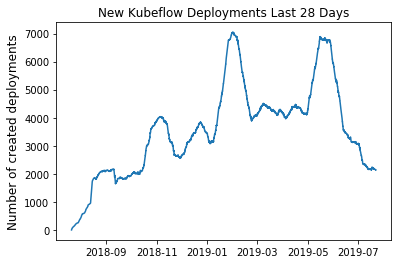

In [13]:
from matplotlib import pyplot as plt
plt.plot(new_deployments.index, new_deployments.values)
plt.title("New Kubeflow Deployments Last 28 Days")
plt.ylabel('Number of created deployments', fontsize='large');

In [14]:
new_per_day_long = pd.Series(data=1, index=long_stats["min_timestamp"])
new_per_day_long = new_per_day_long.sort_index()
new_deployments_long = new_per_day_long.rolling('28d').sum()

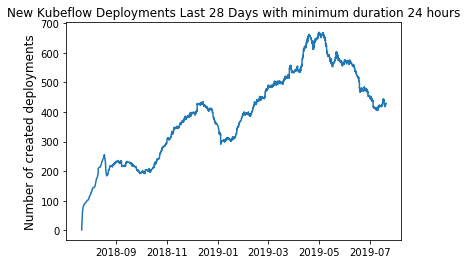

In [15]:
from matplotlib import pyplot as plt
plt.plot(new_deployments_long.index, new_deployments_long.values)
plt.title("New Kubeflow Deployments Last 28 Days with minimum duration 24 hours")
plt.ylabel('Number of created deployments', fontsize='large');

## Number of active deployments

* Compute the number of active deployments at any given time
* We do this by creating a time series of +1 at the first ping and -1 at the last ping
* We then integrate over this time series
* This means we filter out any deployments for which we only have a single ping which means we should exclude clusters with a lifetime of less than 1 day

In [20]:
# We need to drop unknown_cluster and empty string because those represent
# multiple clusters and the min and max timestamp will not correspond to the duration
# of those clusters

filtered_stats = stats[np.logical_and(stats.index != "" , stats.index != "unknown_cluster")]

create_times = pd.Series(data=1, index=filtered_stats["min_timestamp"])
delete_times = pd.Series(data=-1, index=filtered_stats["max_timestamp"])

# Drop delete_times and create_times which are less than 24 hours old.
# We assume those clusters are still active. So we don't want to interpret the
# max ping timestamp as a delete timestamp
now = datetime.datetime.now(delete_times.index.tzinfo)

min_hours = 48
create_times = create_times[now - create_times.index > datetime.timedelta(hours=min_hours)]
delete_times = delete_times[now - delete_times.index > datetime.timedelta(hours=min_hours)]

In [21]:
deltas = pd.concat([create_times, delete_times])
deltas = deltas.sort_index()
active_deployments= deltas.cumsum()

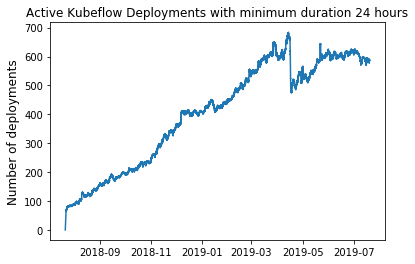

In [22]:
plt.plot(active_deployments.index, active_deployments.values)
plt.title("Active Kubeflow Deployments with minimum duration 24 hours")
plt.ylabel('Number of deployments', fontsize='large');

## Compute histogram of Kubeflow deployment age for

In [23]:
last_28 = stats[now - stats["min_timestamp"] < datetime.timedelta(days=28)]
age_counts = pd.Series(data=1, index=last_28["age"])
age_counts=age_counts.sort_index()
age_stats = age_counts.cumsum()

IndexError: tuple index out of range

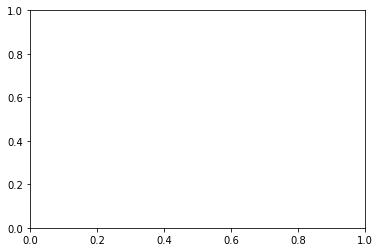

In [24]:
plt.plot(age_stats.index.total_seconds() / (24.0 * 3600), age_stats.values)
plt.title("Kubeflow deployment duration for most recent 28 days")
plt.ylabel('Kubeflow deployment count', fontsize='large');

In [ ]:
# Compute a plot of age stats for clusters that have a minimum age of 1 day
# Excluding short lived clusters filters out short lived automated clusters from testing 
# and other data
last_28_long = last_28[last_28["age"] > datetime.timedelta(hours=24)]
age_counts_long = pd.Series(data=1, index=last_28_long["age"])
age_counts_long=age_counts_long.sort_index()
age_stats_long = age_counts_long.cumsum()
age_cpdf_long = age_stats_long / age_stats_long.max()

In [ ]:
plt.plot(age_stats_long.index.total_seconds() / (24.0 * 3600), age_stats_long.values)
plt.title("Age of Kubeflow deployments for clusters created in last 28 days")
plt.xlabel("Deployment Age(days)")
plt.ylabel('Cumulative deployment count', fontsize='large');

In [ ]:
plt.plot(age_cpdf_long.index.total_seconds() / (24.0 * 3600), age_cpdf_long.values)
now_day = now.strftime("%Y-%m-%d")
plt.title("Age of Kubeflow deployments for clusters created in last 28 days\nTotal deployments={0}\n{1}".format(age_stats_long.max(), now_day))
plt.xlabel("Deployment Age(days)")
plt.ylabel('Cumulative distribution', fontsize='large');

In [ ]:
last_28_long["age"].quantile([.25, .5, .75, .9])